<a href="https://colab.research.google.com/github/fidaasma/groundwater-management-analysis-ai-ml/blob/main/week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔹 Loaded dataset shape: (864, 27)


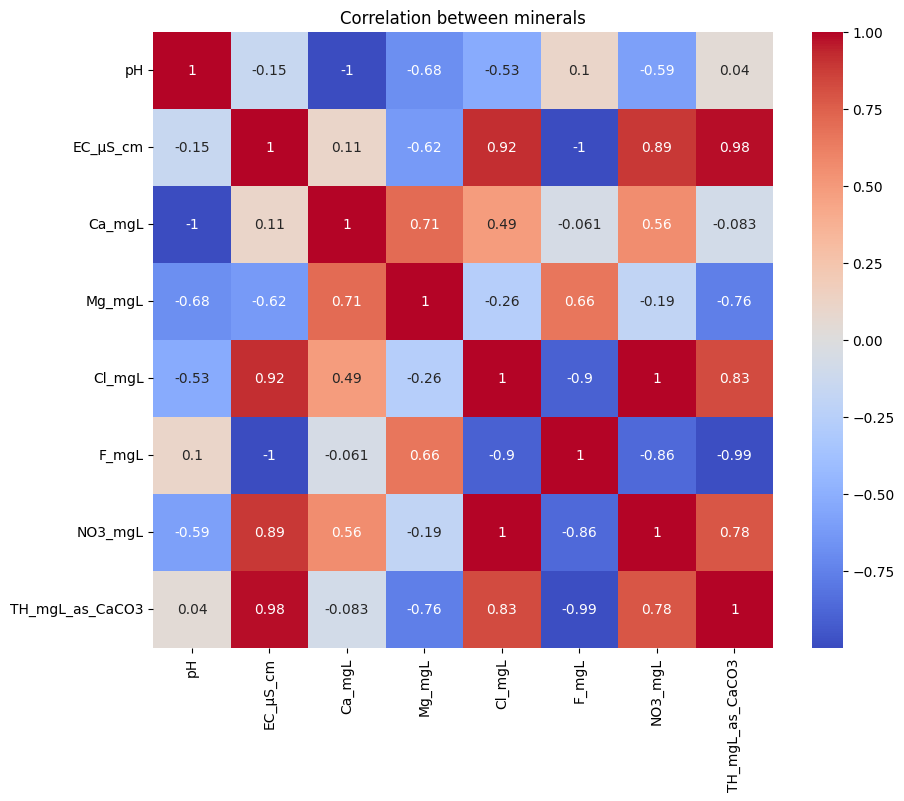

Dropped highly correlated features: ['DecadalAvg_Post_m', 'Ca_mgL', 'Cl_mgL', 'Block_Bharanikkavu']
✅ Feature selection applied. Ready for model training or classification.


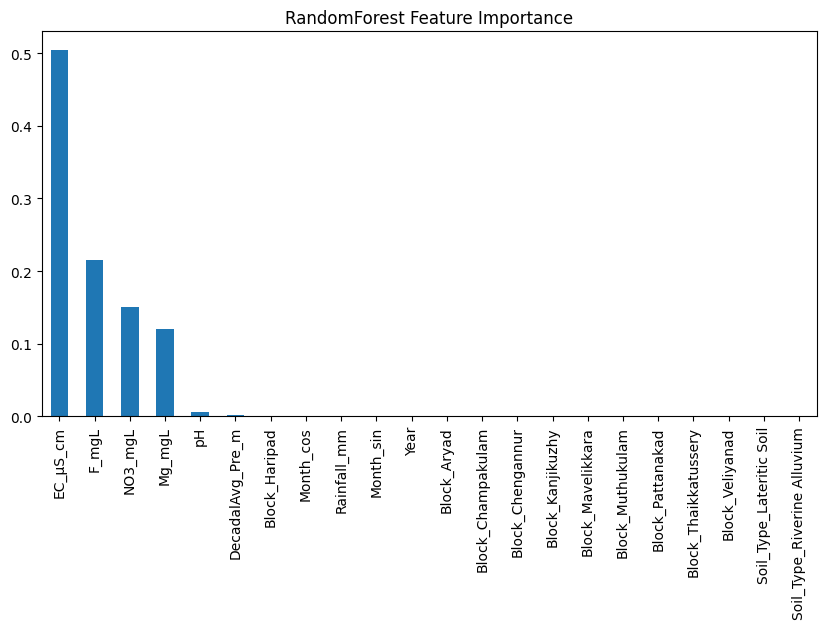

Top 10 features selected by RFE: Index(['Rainfall_mm', 'DecadalAvg_Pre_m', 'pH', 'EC_µS_cm', 'Mg_mgL', 'F_mgL',
       'NO3_mgL', 'Month_sin', 'Month_cos', 'Block_Haripad'],
      dtype='object')
Mutual Information ranking of features:
 Mg_mgL               0.269119
EC_µS_cm             0.258330
pH                   0.203358
F_mgL                0.175740
NO3_mgL              0.111224
DecadalAvg_Pre_m     0.091218
Year                 0.086173
Block_Pattanakad     0.053913
Block_Mavelikkara    0.048022
Block_Haripad        0.043364
dtype: float64
✅ Classified water dataset saved as 'water_quality_classified.csv'

✅ Feature Summary for Accurate Prediction:

RandomForest Top Features:
 EC_µS_cm            5.046700e-01
F_mgL               2.158030e-01
NO3_mgL             1.502690e-01
Mg_mgL              1.204790e-01
pH                  6.292273e-03
DecadalAvg_Pre_m    1.324759e-03
Block_Haripad       1.162012e-03
Month_cos           6.399784e-17
Rainfall_mm         5.607625e-17
Month_sin  

In [4]:
# STEP 1: Load preprocessed dataset
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/cleaned_data.csv')
print("🔹 Loaded dataset shape:", df.shape)
df.head()
# STEP 2: EDA (distribution plots and correlation heatmap)
import matplotlib.pyplot as plt
import seaborn as sns

minerals = ['pH','EC_µS_cm','Ca_mgL','Mg_mgL','Cl_mgL','F_mgL','NO3_mgL','TH_mgL_as_CaCO3']

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df[minerals].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between minerals')
plt.show()
# STEP 3: Data transformation & log1p handling
for col in ['NO3_mgL', 'F_mgL']:
    if col in df.columns:
        df[col] = df[col].fillna(0)
        df[col] = df[col].apply(lambda x: max(x, 0))
        df[col] = np.log1p(df[col])
# STEP 4: Feature selection with KeyError fix
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE, mutual_info_regression

# --- Keep target column safe ---
target = 'TH_mgL_as_CaCO3'

# 1. Separate features and target
features = df.drop(columns=[target])
y = df[target]

# 2. Drop highly correlated features from features only
corr_matrix = features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]
features = features.drop(columns=to_drop)
print("Dropped highly correlated features:", to_drop)

# 3. Final dataset ready
X = features
df_reduced = pd.concat([X, y], axis=1)
print("✅ Feature selection applied. Ready for model training or classification.")
# STEP 5: RandomForest Feature Importance
rf_model = RandomForestRegressor()
rf_model.fit(X, y)

importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,5))
plt.title("RandomForest Feature Importance")
plt.show()
# STEP 6: Recursive Feature Elimination (RFE)
rfe = RFE(rf_model, n_features_to_select=10)
rfe.fit(X, y)
selected_features = X.columns[rfe.support_]
print("Top 10 features selected by RFE:", selected_features)
# STEP 7: Mutual Information
mi = mutual_info_regression(X, y)
mi_series = pd.Series(mi, index=X.columns)
mi_series.sort_values(ascending=False, inplace=True)
print("Mutual Information ranking of features:\n", mi_series.head(10))
# STEP 8: Water quality classification
def classify_water(row):
    # Drinking water safe limits
    drink = "Safe" if row['F_mgL'] <= np.log1p(1.5) and row['NO3_mgL'] <= np.log1p(45) and row['TH_mgL_as_CaCO3'] <= 500 else "Unsafe"
    # Bathing safe limits
    bath = "Safe" if row['TH_mgL_as_CaCO3'] <= 500 and 6.5 <= row['pH'] <= 9 else "Unsafe"
    # Irrigation safe limits
    irrig = "Safe" if row['TH_mgL_as_CaCO3'] <= 500 and row['EC_µS_cm'] <= 2000 else "Unsafe"

    return pd.Series([drink, bath, irrig])

df_reduced[['Drinking','Bathing','Irrigation']] = df_reduced.apply(classify_water, axis=1)
df_reduced.head()
# STEP 9: Save the final classified dataset
df_reduced.to_csv("water_quality_classified.csv", index=False)
print("✅ Classified water dataset saved as 'water_quality_classified.csv'")
# STEP 10: Summary of Most Important Features
print("\n✅ Feature Summary for Accurate Prediction:\n")
print("RandomForest Top Features:\n", importances.sort_values(ascending=False).head(10))
print("\nRFE Selected Features:\n", selected_features)
print("\nMutual Information Top Features:\n", mi_series.head(10))
